# Mobility V2 API

Currently we offer data from a number of citybike and scooter operators in several Norwegian cities.

All of our data is served in version 2.2 of the General Bikeshare Feed Specification (GBFS) format which is a standardized data feed for micro-mobility systems.

In [1]:
import requests as rq
import json
import pandas as pd
from utils import keysofkeys

headers = {
    "Content-Type": "application/json",
    "ET-Client-Name": "mikalst-testing"
}

## Using GraphQL

In [30]:
url = "https://api.entur.io/mobility/v2/graphql"
q = """
{
  vehicles(
    lat: 59.9226939
    lon: 10.6781036
    range: 2000
    count: 100
    formFactors: SCOOTER
    includeDisabled: false
    includeReserved: false
  ) {
    lat
    lon
    pricingPlan {
      description {
        translation {
          language
          value
        }
      }
      price
      perMinPricing {
        end
        interval
        start
        rate
      }
      perKmPricing {
        end
        interval
        rate
        start
      }
      isTaxable
      id
    }
    isDisabled
    isReserved
    currentRangeMeters
    system {
        operator {
            name {
              translation {
                value
              }
            }
          }
    }
  }
}
"""

body = {
    "query": q,
    "variables": None
}
r = rq.post(url, data = json.dumps(body), headers=headers)
response = json.loads(r.content)

In [31]:
keysofkeys(response)

 dict_keys(['data'])
 data dict_keys(['vehicles'])
 data vehicles dict_keys(['lat', 'lon', 'pricingPlan', 'isDisabled', 'isReserved', 'currentRangeMeters', 'system'])
 data vehicles pricingPlan dict_keys(['description', 'price', 'perMinPricing', 'perKmPricing', 'isTaxable', 'id'])
 data vehicles pricingPlan description dict_keys(['translation'])
 data vehicles pricingPlan description translation dict_keys(['language', 'value'])
 data vehicles pricingPlan perMinPricing dict_keys(['end', 'interval', 'start', 'rate'])
 data vehicles system dict_keys(['operator'])
 data vehicles system operator dict_keys(['name'])
 data vehicles system operator name dict_keys(['translation'])
 data vehicles system operator name translation dict_keys(['value'])


In [32]:
response['data']['vehicles'][0]

{'lat': 59.921888,
 'lon': 10.676695,
 'pricingPlan': {'description': {'translation': [{'language': 'nb',
     'value': '10 kr + 2,50 kr / min'}]},
  'price': 10.0,
  'perMinPricing': [{'end': None, 'interval': 1, 'start': 0, 'rate': 2.5}],
  'perKmPricing': None,
  'isTaxable': False,
  'id': 'YTI:PricingPlan:Basic'},
 'isDisabled': False,
 'isReserved': False,
 'currentRangeMeters': 21248.0,
 'system': {'operator': {'name': {'translation': [{'value': 'Tier'}]}}}}

In [33]:
bike_details = [(
    b['lon'],
    b['lat'],
    b['currentRangeMeters'],
    b['pricingPlan']['description']['translation'][0]['value'],
    b["system"]["operator"]["name"]["translation"][0]["value"]) for b in response['data']['vehicles']]
df = pd.DataFrame(bike_details, columns=("lon", "lat", "range", "price", "provider"))
df_selected = df[df['range']>0]

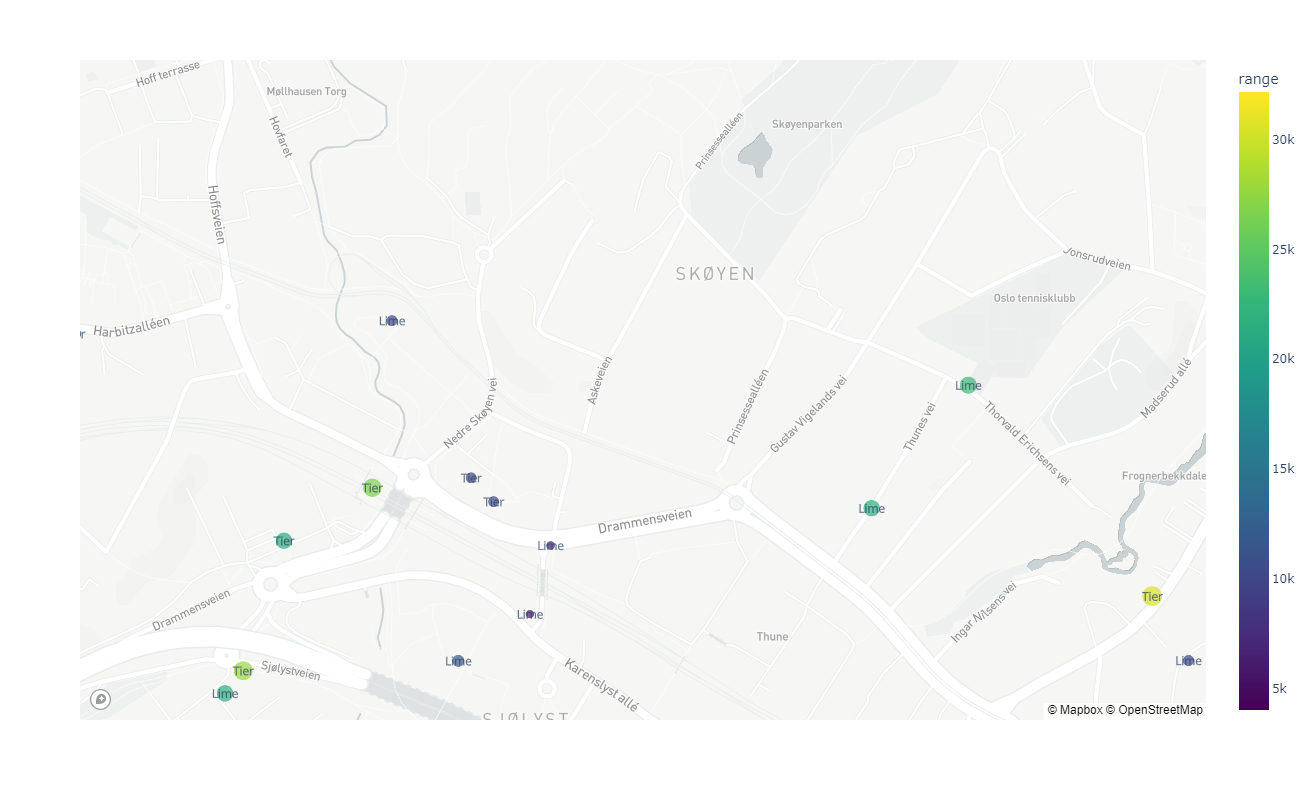

In [35]:
import plotly.express as px
px.set_mapbox_access_token(open(".mapbox_token").read())
fig = px.scatter_mapbox(
    df_selected, 
    lat="lat", 
    lon="lon",
    color="range",
    size="range",
    text="provider",
    hover_data=["price"], color_continuous_scale=px.colors.sequential.Viridis, size_max=15, zoom=15, height=800)
fig.show()